In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import pyreadr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from numpy import linalg as LA

### Spreads

$\frac{dS^i}{S^i} = \sum_{l} \beta_{i,l} \frac{dI^l}{I^l} + dZ^i$

In [18]:
# file path for SP500 returns data
filepath = 'data/sp500_data.csv'

df = pd.read_csv(filepath)
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.set_index('date',inplace=True)

In [19]:
# 442 stock returns over 5 years - 1258 days
print('shape: {}'.format(df.shape))
# last date
print('last date: {}'.format(df.index[-1]))

shape: (1259, 442)
last date: 2019-10-04


In [20]:
# get rid of _price, change to pct and clean
col_list = []
for i in df.columns:
    col_list.append(i.split('_', 1)[0])
df.columns = col_list

df = df.pct_change()
df = df.dropna(axis=0)

In [21]:
import glob

path = '/Users/zachariemartin/Desktop/School/Projects/summer2019/2/sum19/data/etf data'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_ = pd.read_csv(filename, usecols=[4], header='infer')
    li.append(df_)

etf_df = pd.concat(li, axis=1, ignore_index=True)

In [22]:
etf_df = etf_df.pct_change()
etf_df = etf_df.dropna(axis=0)

In [23]:
# 9 etf returns over 5 years - 1258 days

x = etf_df.values
x.shape

(1258, 9)

In [31]:
# throw out intercept

from sklearn import linear_model

# regress on each stocks returns, save residuals
reg = linear_model.LinearRegression(fit_intercept=False)
x = etf_df.values 
df_residuals = pd.DataFrame(columns=df.columns)

for i in range(df.shape[1]):
    y = df.iloc[:,i].values.reshape(-1,1)
    reg.fit(x,y)
    w = reg.coef_
    b = reg.intercept_
    df_residuals.iloc[:,i] = (y-(x@w.T + b)).flatten()

In [32]:
# compare this cell and the one below
df_residuals.head()

,AAPL,ACN,AMG,AMT,ANTM,BBBY,BK,CAH,DE,DLTR,...,MLM,MSFT,NFLX,O,PCAR,SRCL,TGNA,TXT,V,WU
0,0.006154,-0.007869,0.006762,-0.000863,0.003066,0.015486,-0.005636,-0.001046,-0.007980,0.011531,...,-0.002786,0.002844,0.003816,-0.001981,0.001481,0.006961,0.007732,-0.004447,-0.002629,-0.002995
1,0.003695,-0.005921,0.001593,0.003315,-0.004218,0.001876,-0.000052,0.005139,0.001570,-0.002499,...,-0.009441,0.006164,0.001839,0.007510,0.017002,-0.002338,-0.009323,-0.003535,0.000568,0.005938
2,0.014483,-0.002763,-0.000345,0.008392,0.013893,0.019873,-0.010822,0.005232,0.021588,0.009543,...,0.002278,-0.003077,0.015848,0.026125,0.004183,0.012287,-0.016860,-0.005652,-0.003823,-0.012540
3,0.031347,-0.002469,0.000147,0.000180,-0.011363,-0.021116,-0.003570,0.001655,0.016587,-0.014162,...,-0.020429,-0.011139,0.005169,-0.010419,0.000114,-0.003311,-0.015888,0.009501,0.007079,-0.000620
4,-0.002215,0.006749,-0.004672,-0.007954,0.000460,0.001008,-0.003530,0.004324,0.025657,0.009701,...,-0.016232,0.001532,-0.004094,0.008881,0.004517,0.013349,-0.006884,-0.008634,0.009201,0.005154


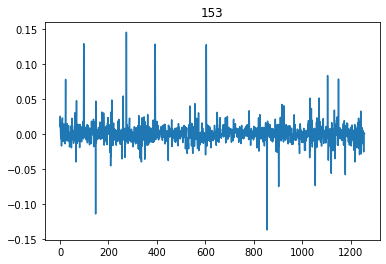

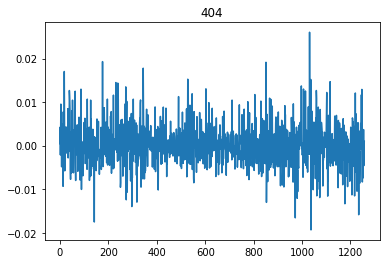

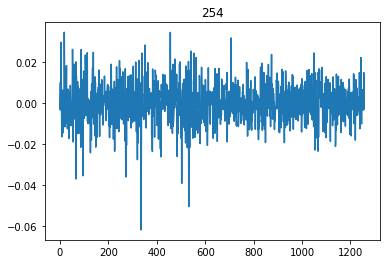

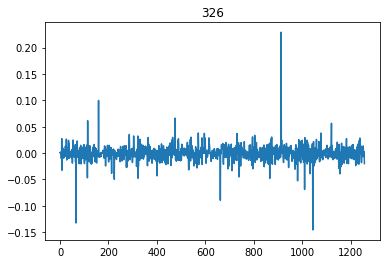

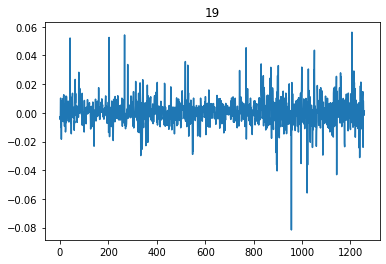

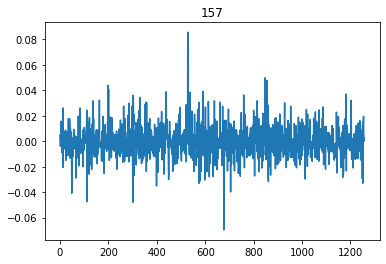

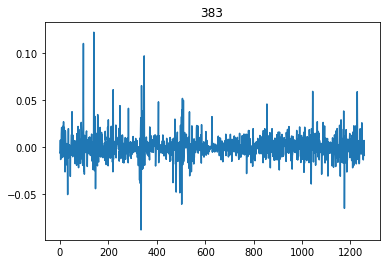

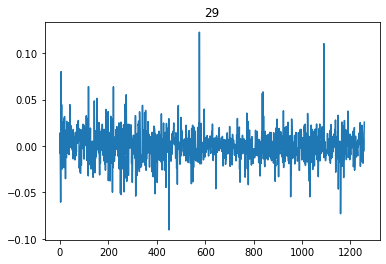

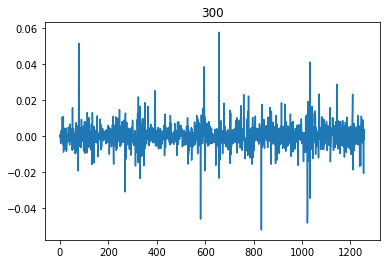

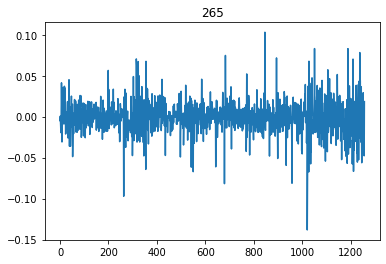

In [34]:
#compare 10 random plots
x = np.random.randint(low=0,high=df_residuals.shape[1],size=10)

if True:
    for i in x:
        plt.figure(i)
        plt.plot(df_residuals.iloc[:,i])
        plt.title(i)

In [36]:
# compare this cell and the one above
df_residuals_cumsum = df_residuals.cumsum(axis=0)
df_residuals_cumsum.head()

,AAPL,ACN,AMG,AMT,ANTM,BBBY,BK,CAH,DE,DLTR,...,MLM,MSFT,NFLX,O,PCAR,SRCL,TGNA,TXT,V,WU
0,0.006154,-0.007869,0.006762,-0.000863,0.003066,0.015486,-0.005636,-0.001046,-0.007980,0.011531,...,-0.002786,0.002844,0.003816,-0.001981,0.001481,0.006961,0.007732,-0.004447,-0.002629,-0.002995
1,0.009849,-0.013791,0.008355,0.002453,-0.001152,0.017361,-0.005689,0.004093,-0.006410,0.009033,...,-0.012227,0.009008,0.005655,0.005529,0.018483,0.004623,-0.001590,-0.007982,-0.002061,0.002943
2,0.024332,-0.016553,0.008010,0.010845,0.012740,0.037234,-0.016510,0.009325,0.015178,0.018575,...,-0.009949,0.005931,0.021503,0.031654,0.022665,0.016909,-0.018450,-0.013634,-0.005885,-0.009597
3,0.055679,-0.019023,0.008157,0.011025,0.001377,0.016118,-0.020080,0.010980,0.031765,0.004413,...,-0.030378,-0.005208,0.026672,0.021235,0.022780,0.013598,-0.034338,-0.004133,0.001195,-0.010217
4,0.053464,-0.012273,0.003485,0.003070,0.001837,0.017126,-0.023611,0.015304,0.057422,0.014114,...,-0.046610,-0.003675,0.022577,0.030115,0.027297,0.026947,-0.041223,-0.012767,0.010396,-0.005062


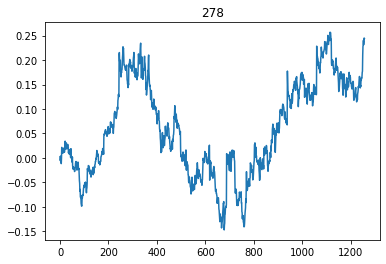

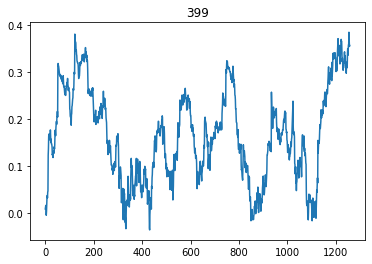

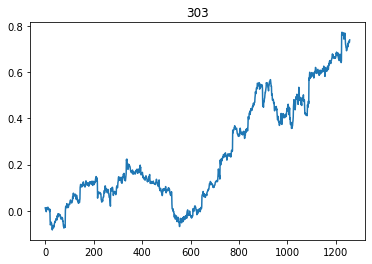

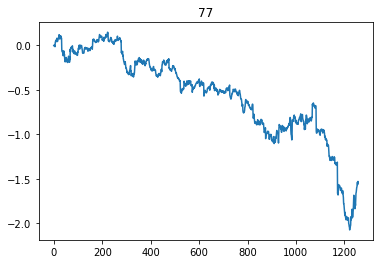

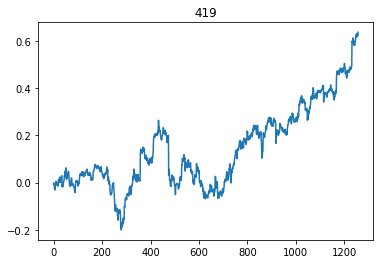

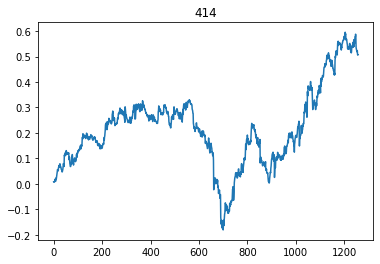

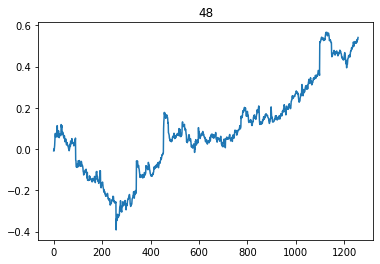

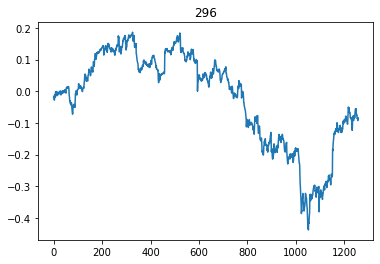

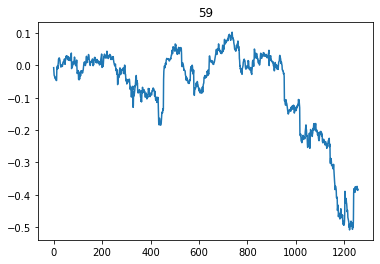

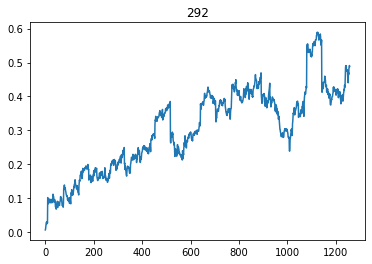

In [37]:
#compare 40 plots
x = np.random.randint(low=0,high=df_residuals.shape[1],size=10)

if True:
    for i in x:
        plt.figure(i)
        plt.plot(df_residuals_cumsum.iloc[:,i])
        plt.title(i)

In [29]:
df_residuals.set_index(df.index,inplace=True)

In [30]:
from statsmodels.tsa.stattools import adfuller

df_df = pd.DataFrame(columns=['ADF Statistic','p-value','n lags used'],index=df_residuals.columns)

# test residuals for stationarity and return adf statistic and p-value, columns 0 and 1 respectively
for i in range(df_residuals.shape[1]):
    result = adfuller(df.iloc[:,i])
    df_df.iloc[i,0] = result[0]
    df_df.iloc[i,1] = result[1]
    df_df.iloc[i,2] = result[2]


In [31]:
# check for significance at 5%
np.where(df_df.iloc[:,1] > .05)

(array([], dtype=int64),)

In [32]:
df_df

,ADF Statistic,p-value,n lags used
AAPL,-10.8282,1.73499e-19,8
ACN,-26.5612,0,1
AMG,-34.0833,0,0
AMT,-13.8091,8.29393e-26,8
ANTM,-36.7231,0,0
BBBY,-35.7298,0,0
BK,-34.7934,0,0
CAH,-36.784,0,0
DE,-35.4293,0,0
DLTR,-16.9549,9.40131e-30,3


In [38]:
# save results to csv
path = 'data/zprocess_data.csv'
df_residuals.to_csv(path)

In [6]:
# plot spreads
df_z = pd.read_csv('/Users/zachariemartin/Desktop/School/Projects/summer2019/2/sum19/data/zprocess_data.csv')

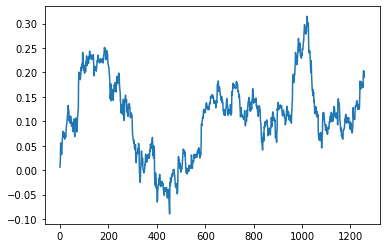

In [14]:
plt.plot(df_z.iloc[:,1])

In [15]:
df_z.shape[1]+1

444

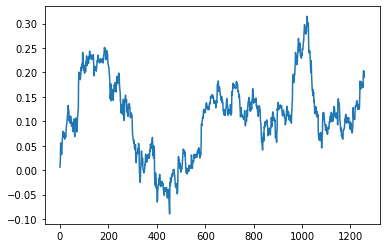

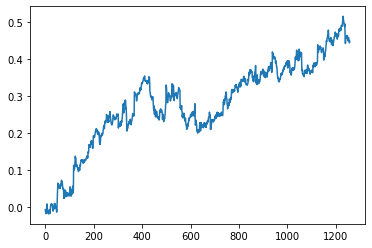

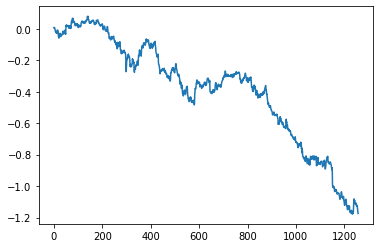

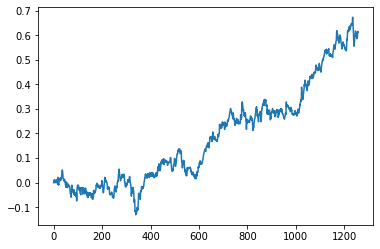

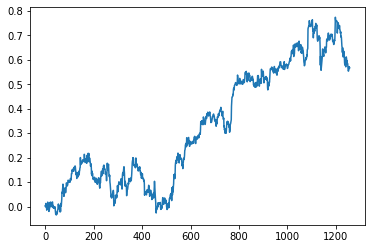

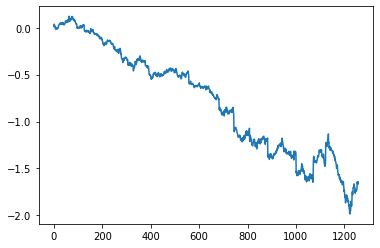

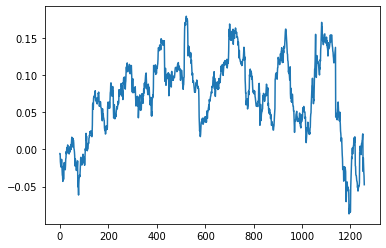

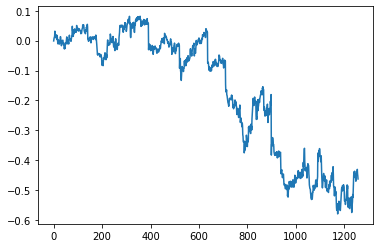

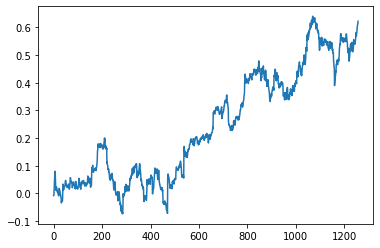

In [16]:
# plot "returns" to see if they make sense   
if True:
    for i in range(1,10):
        plt.figure(i)
        plt.plot(df_z.iloc[:,i])